In [1]:
import matplotlib

import numpy as np
import keras
import tensorflow as tf
import itertools    

from keras.layers.advanced_activations import LeakyReLU, PReLU, ELU
from keras.layers import Conv2D, MaxPooling2D, Flatten, Input, Dense, Dropout, Reshape, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1,l2

from keras.models import Model
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt

from load_data import load

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.
sys.version_info(major=2, minor=7, micro=6, releaselevel='final', serial=0)


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
keras.backend.set_session(sess)

In [3]:
def autoencoder(X_train, X_test):
    input_layer = Input(shape=(48,48,3))
    
    #Phase 1 of training
    encoder = Flatten()(input_layer)
    encoder = Dense(3456, activation='sigmoid')(encoder)
    decoder = Dense(48*48*3, activation='sigmoid')(encoder)
    decoder = Reshape((48,48,3))(decoder)
    opt = keras.optimizers.Adadelta()
    autoencoder = Model(input_layer, decoder)
    autoencoder.compile(optimizer=opt, loss='mean_squared_error')  
    autoencoder.fit(X_train, X_train, epochs=100, batch_size=4, validation_split=0.2, callbacks=[ModelCheckpoint('./tomato', save_best_only=False, period=10)])
    
    for layer in autoencoder.layers:
        layer.trainable = False
    
    #Phase 2 of training
    encoder = Dense(1728, activation='sigmoid')(encoder)
    
    decoder = Dense(3456, activation='sigmoid')(encoder)
    decoder = Dense(48*48*3, activation='sigmoid')(decoder)
    decoder = Reshape((48,48,3))(decoder)
    
    autoencoder2 = Model(input_layer, decoder)
    opt = keras.optimizers.Adadelta()
    autoencoder2.compile(optimizer=opt, loss='mean_squared_error')
    
    autoencoder2.fit(X_train, X_train, epochs=10, batch_size=4, validation_split=0.2, callbacks=[ModelCheckpoint('./avocado', save_best_only=False, period=10)])
    print(autoencoder2.evaluate(X_test, X_test))
    
    encoder = Model(input_layer, encoder)
    return autoencoder2, encoder, input_layer

In [4]:
def downsample(X):
    import Image
    resized = []
    for x in X:
        img = Image.fromarray(np.uint8(x * 255))
        resized.append(np.asarray(img.resize((48, 48), Image.NEAREST)).astype('float32')/255.0)
    return np.array(resized)

In [5]:
def reconstruct_image(vae, images, index=0):
    x_test = vae.predict(images)
    x_test = np.uint8(x_test * 255)
    plot_image = np.concatenate((np.uint8(images[index]*255), x_test[index]), axis=1)
    imgplot = plt.imshow(plot_image)

In [6]:
(X_train, Y_train), (X_test, Y_test), cross_val_indices = load()
X_train = downsample(X_train) 
X_test = downsample(X_test)
aec, enc, inp = autoencoder(X_train, X_test)

aec.save("part2_aec")
enc.save("part2_enc")

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 106s - loss: 0.0362 - val_loss: 0.0359
Epoch 2/10
4000/4000 [==============================] - 108s - loss: 0.0361 - val_loss: 0.0357
Epoch 3/10
4000/4000 [==============================] - 108s - loss: 0.0360 - val_loss: 0.0357
Epoch 4/10
4000/4000 [==============================] - 95s - loss: 0.0360 - val_loss: 0.0356
Epoch 5/10
4000/4000 [==============================] - 90s - loss: 0.0359 - val_loss: 0.0355
Epoch 6/10
4000/4000 [==============================] - 97s - loss: 0.0358 - val_loss: 0.0356
Epoch 7/10
4000/4000 [==============================] - 96s - loss: 0.0357 - val_loss: 0.0353
Epoch 8/10
4000/4000 [==============================] - 97s - loss: 0.0356 - val_loss: 0.0353
Epoch 9/10
4000/4000 [==============================] - 96s - loss: 0.0355 - val_loss: 0.0351
Epoch 10/10
8000/8000 [==============================] - 1s     
0.0351763281226


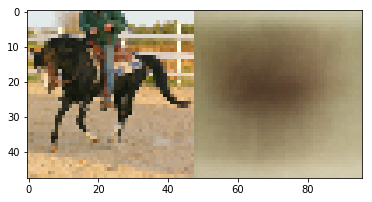

In [7]:
reconstruct_image(aec, X_test, 0)
plt.show()

In [8]:
def make_model_from_enc(inp, enc):
    encoder = Dense(864, activation='sigmoid')(enc)
    encoder = Dense(432, activation='sigmoid')(encoder)
    encoder = Dense(10, activation='softmax')(encoder)
    whole_model = Model(inp, encoder)
    opt = keras.optimizers.Adadelta()
    whole_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[ 'acc'])
    whole_model.fit(X_train, Y_train, epochs=100, batch_size=4, validation_split=0.2, callbacks=[ModelCheckpoint('./not_together', save_best_only=False, period=10)])
    print(whole_model.evaluate(X_test, Y_test))
    return whole_model

In [9]:
final_model = make_model_from_enc(inp, enc.output)

Train on 4000 samples, validate on 1000 samples
Epoch 1/100
4000/4000 [==============================] - 59s - loss: 2.2218 - acc: 0.1378 - val_loss: 2.2017 - val_acc: 0.1800
Epoch 2/100
4000/4000 [==============================] - 36s - loss: 1.9873 - acc: 0.2332 - val_loss: 1.9149 - val_acc: 0.2550
Epoch 3/100
4000/4000 [==============================] - 29s - loss: 1.9051 - acc: 0.2658 - val_loss: 1.9663 - val_acc: 0.2500
Epoch 4/100
4000/4000 [==============================] - 29s - loss: 1.8565 - acc: 0.2745 - val_loss: 1.8596 - val_acc: 0.2730
Epoch 5/100
4000/4000 [==============================] - 29s - loss: 1.8171 - acc: 0.2885 - val_loss: 1.8686 - val_acc: 0.2860
Epoch 6/100
4000/4000 [==============================] - 29s - loss: 1.7727 - acc: 0.3055 - val_loss: 1.7851 - val_acc: 0.3160
Epoch 7/100
4000/4000 [==============================] - 29s - loss: 1.7392 - acc: 0.3210 - val_loss: 1.8451 - val_acc: 0.3050
Epoch 8/100
4000/4000 [==============================] - 29s - 